# Introduction

Code adapted from: https://github.com/DmitryUlyanov/deep-image-prior/blob/master/inpainting.ipynb   

1. v0. Make sure the image is normalized   
    Modifications to the following files:   
    1. utils.common_utils.py: **optimize** now returns loss   
    1. utils.common_utils.py: **plot_image_grid** plots viridis without interpolation

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [2]:
import imageio
from matplotlib import rcParams
from copy import copy
from scipy import ndimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
from skimage import measure, morphology

In [61]:
def set_all_rcParams(true_or_false):
    rcParams['ytick.left']=true_or_false
    rcParams['ytick.right']=true_or_false
    rcParams['xtick.top']=true_or_false
    rcParams['xtick.bottom']=true_or_false
    rcParams['ytick.labelleft'] = true_or_false
    rcParams['ytick.labelright'] = true_or_false
    rcParams['xtick.labeltop'] = true_or_false
    rcParams['xtick.labelbottom'] = true_or_false

# Functions

In [29]:
def plot_for_gif(image_to_save,num_iter, i):
    fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[8, 1]}, figsize=(14,10))
    ax[0].imshow(image_to_save, cmap='viridis')
    ax[0].axis('off')
    ax[1].axvline(x=.5, c='k')
    ax[1].scatter(.5, i, c='k')
    ax[1].set_ylim([num_iter, 0])
    ax[1].yaxis.tick_right()
    ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    # ax[1].xticks([], [])
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["bottom"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    plt.subplots_adjust(wspace=.04, hspace=0)
    plt.savefig(f'{path_img_dest}images before gifs/iter {i:05d}.jpeg',
                bbox_inches = 'tight',pad_inches = 0)
    return fig

In [41]:
xxx='fd'
f'{xxx}{56}'

'fd56'

In [42]:
def save_original(image_to_save, id_name, name_extension):
    name_extension = str(name_extension)
    fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[8, 1]}, figsize=(14,10))
    ax[0].imshow(image_to_save, cmap='viridis')
    ax[0].axis('off')
    ax[1].axvline(x=.5, c='k')
    ax[1].set_ylim([num_iter, 0])
    ax[1].yaxis.tick_right()
    ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["bottom"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    plt.subplots_adjust(wspace=.04, hspace=0)
    fig.savefig(f'{path_img_dest}gifs/dip {id_name} {name_extension}.jpeg',
                bbox_inches = 'tight',pad_inches = 0)

In [6]:
def plot_3d(image, threshold=-300, alpha=.70, fig_size=10):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, x,y = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

# Choose figure

In [7]:
path_data = f'/media/om18/TOSHIBA EXT/KCL/Data/LIDC 3D reconstruction 80px v3 - with coords/3Dvolumes/'

In [8]:
idnumber = 12
idname = f'LIDC-IDRI-{idnumber:04d}'
files = os.listdir(f'{path_data}masks')
file_mask = [i for i in files if idname in i]
files = os.listdir(f'{path_data}lungs')
file_lungs = [i for i in files if idname in i]
#==
lungs = np.load(f'{path_data}lungs/{file_lungs[0]}')
lungs = lungs.f.arr_0
mask = np.load(f'{path_data}masks/{file_mask[0]}')
mask= mask.f.arr_0

In [ ]:
plot_3d(mask, threshold=0, fig_size=7)

## Find the location of the nodules in the reconstruction

In [10]:
# We can get the number from the annotations.csv
df_annotations = pd.read_csv('/data/datasets/LIDC-IDRI/annotations.csv')
df_patient = df_annotations.loc[df_annotations['patientid']==idnumber]
nodules_per_patient = len(np.unique(df_patient['cluster_id'].values))
print(f'nodules_per_patient: {nodules_per_patient}')

nodules_per_patient: 12


In [11]:
df_patient_display = df_patient.drop(['Unnamed: 0', 'studyuid', 'diagnosis', 'method', 'primary_tumor_site', 'nodule_1_diagnosis', 'nodule_1_method', 'is_diagnosed', 'seriesuid'], axis=1)
# df_patient_display

In [12]:
str_3D_strict=np.array([[[0, 0, 0],[0, 1, 0],[0, 0, 0]],
                        [[0, 1, 0],[1, 1, 1],[0, 1, 0]],
                        [[0, 0, 0],[0, 1, 0],[0, 0, 0]]], dtype='uint8')
str_3D=np.array([[[1, 1, 1],[1, 1, 1],[1, 1, 1]],
                 [[1, 1, 1],[1, 1, 1],[1, 1, 1]],
                 [[1, 1, 1],[1, 1, 1],[1, 1, 1]]], dtype='uint8')

In [13]:
nodules_per_patient = len(np.unique(df_patient['cluster_id'].values))
print(f'nodules_per_patient: {nodules_per_patient}')

nodules_per_patient: 12


# Check mask

In [14]:
labeled, nr_objects = ndimage.label(mask, structure=str_3D) 
nr_objects

11

In [51]:
np.shape(lungs_slice)

(1, 224, 288)

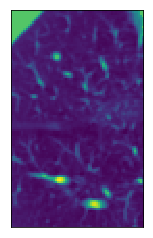

In [65]:
extra=20
plt.imshow(lungs_slice[0][np.min(y)-extra:np.max(y)+extra*4, np.min(x)-extra:np.max(x)+extra*2])

(197, 271) (197, 271)


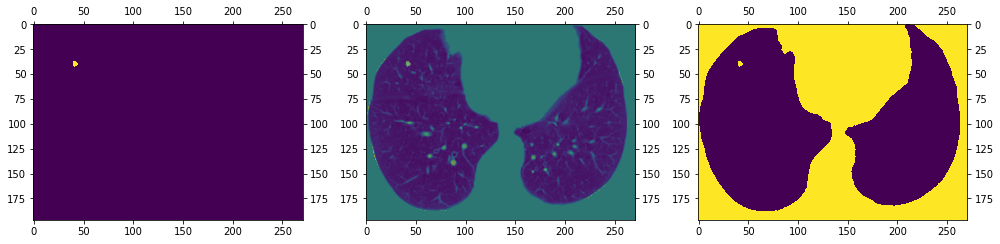

In [31]:
z, y, x = np.where(labeled==1)
take_one_slice = int(np.median(z))
mask_slice_nodule = mask[take_one_slice]
lungs_slice = lungs[take_one_slice]
# Mask also the region outside the lungs
outside_lungs = lungs_slice==0
mask_slice = copy(mask_slice_nodule)
mask_slice[outside_lungs] = 1
print(np.shape(lungs_slice), np.shape(mask_slice))
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].imshow(mask_slice_nodule)
ax[1].imshow(lungs_slice)
ax[1].imshow(mask_slice_nodule, alpha=.3)
ax[2].imshow(mask_slice)
fig.tight_layout()

In [16]:
def padd_divisible_encoder_blocks(img):
    deficit = 224 - np.shape(img_np)[1]
    deficit2 = 288 - np.shape(img_np)[2]

In [17]:
deficit = 224 - np.shape(lungs_slice)[0]
deficit2 = 288 - np.shape(lungs_slice)[1]

In [32]:
mask_slice = 1 - mask_slice

lungs_slice = np.pad(lungs_slice, ((0,deficit), (0,0)), mode='constant')
lungs_slice = np.pad(lungs_slice, ((0,0), (0,deficit2)), mode='constant')
mask_slice = np.pad(mask_slice, ((0,deficit), (0,0)), mode='constant')
mask_slice = np.pad(mask_slice, ((0,0), (0,deficit2)), mode='constant')
outside_lungs = np.pad(outside_lungs, ((0,deficit), (0,0)), mode='constant', constant_values=1)
outside_lungs = np.pad(outside_lungs, ((0,0), (0,deficit2)), mode='constant', constant_values=1)

lungs_slice = (lungs_slice - np.min(lungs_slice))/(np.max(lungs_slice)-np.min(lungs_slice))

lungs_slice = np.expand_dims(lungs_slice, 0)
mask_slice = np.expand_dims(mask_slice, 0)
outside_lungs = np.expand_dims(outside_lungs, 0)

img_np = lungs_slice
img_mask_np = mask_slice
print(np.shape(img_np), np.shape(img_mask_np))
np.shape(lungs_slice)

(1, 224, 288) (1, 224, 288)


(1, 224, 288)

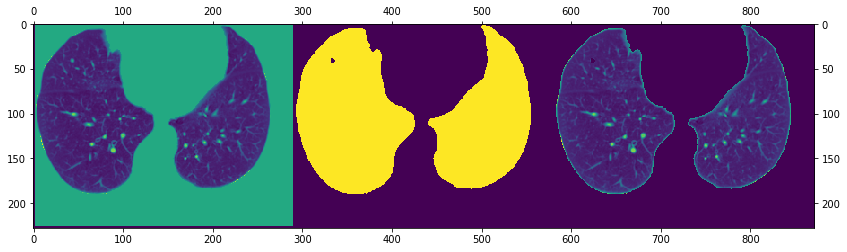

In [33]:
plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

In [ ]:
plt.hist(lungs_slice.flatten(), bins=50);

In [ ]:
plt.hist(lungs_slice.flatten(), bins=50);
plt.xlim([.59, 1.1])

In [ ]:
for i in range(15):
    print(32*i)

# Previous image

In [ ]:
z, y, x = np.where(mask!=0)
take_one_slice = int(np.median(z))+3

In [ ]:
y1=38
x1=180
size_temp = 64
lung_patch = lungs[take_one_slice][y1:y1+size_temp,x1:x1+size_temp]
# mask_patch = mask[take_one_slice][28:170,184:230]
mask_patch = mask[take_one_slice][y1:y1+size_temp,x1:x1+size_temp]
lung_patch = np.rot90(lung_patch)
mask_patch = np.rot90(mask_patch)
mask_patch =1-mask_patch

In [ ]:
np.unique(mask_patch)

In [ ]:
img_np = (lung_patch - np.min(lung_patch))/(np.max(lung_patch)-np.min(lung_patch))
img_np = np.expand_dims(img_np,0)
img_mask_np = mask_patch
img_mask_np = np.expand_dims(img_mask_np, 0)
fig, ax = plt.subplots(2,2,figsize=(14,8))
ax[0,0].imshow(img_np[0])
ax[0,1].imshow(mask_patch)
ax[1,0].imshow(img_mask_np[0]*img_np[0])
ax[1,1].hist(img_np.flatten(),bins=50);

In [ ]:
np.shape(img_np),np.shape(img_mask_np)

In [ ]:
plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [21]:
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

In [22]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [23]:
img_np.shape[0]

1

In [46]:
INPUT = 'noise'
input_depth = 1
LR = 0.01 
num_iter = 8001
param_noise = False
show_every = 400
figsize = 5
reg_noise_std = 0.03

net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5,
           num_channels_up   = [128] * 5,
           num_channels_skip = [0] * 5,  
           upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

In [35]:
net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [36]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 2156545


# Main loop

In [37]:
path_img_dest = 'OMM - gifs 5/'

Starting optimization with ADAM


/home/om18/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


/home/om18/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


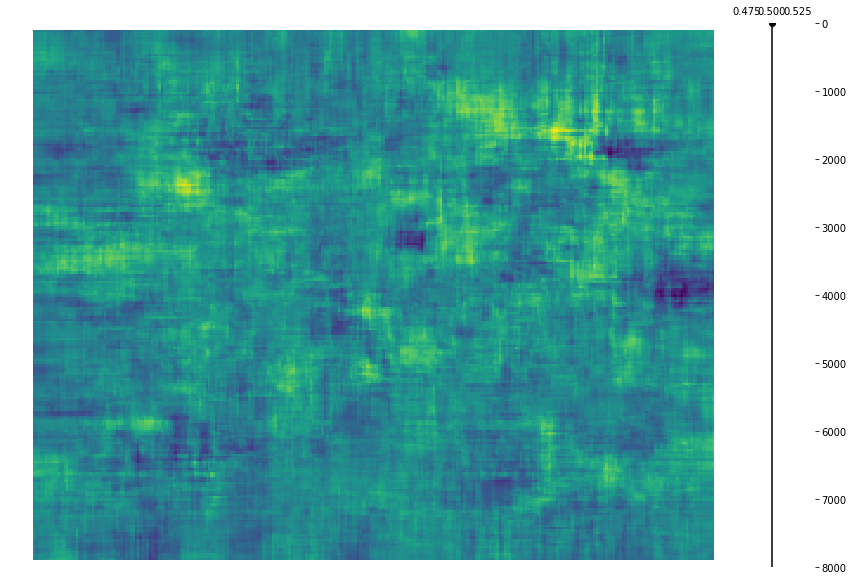

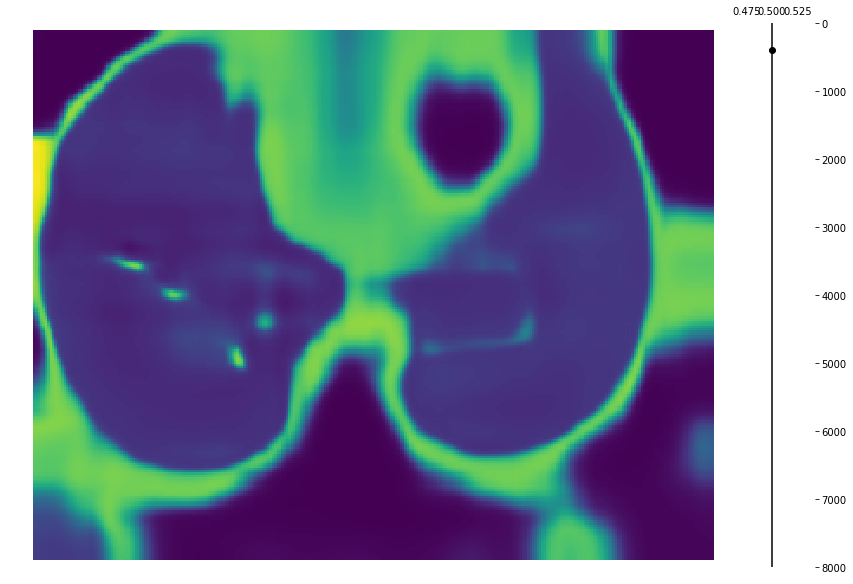

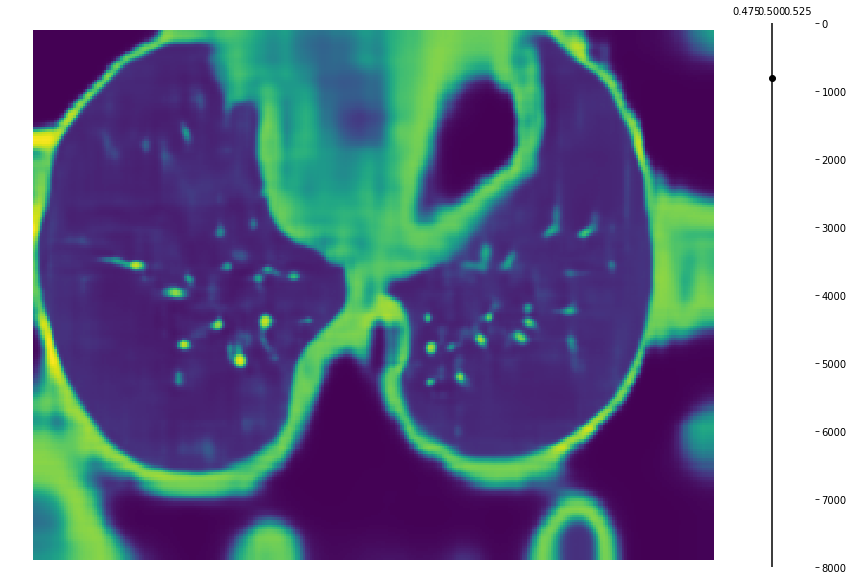

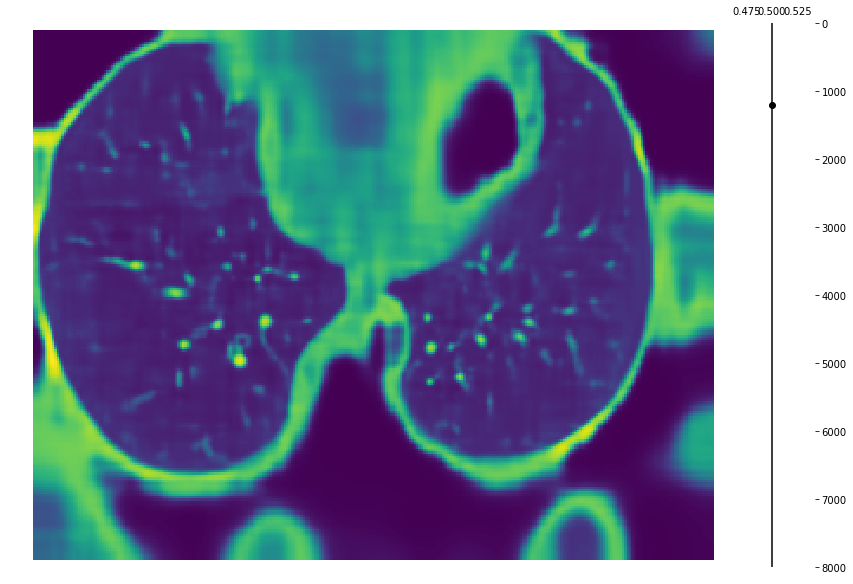

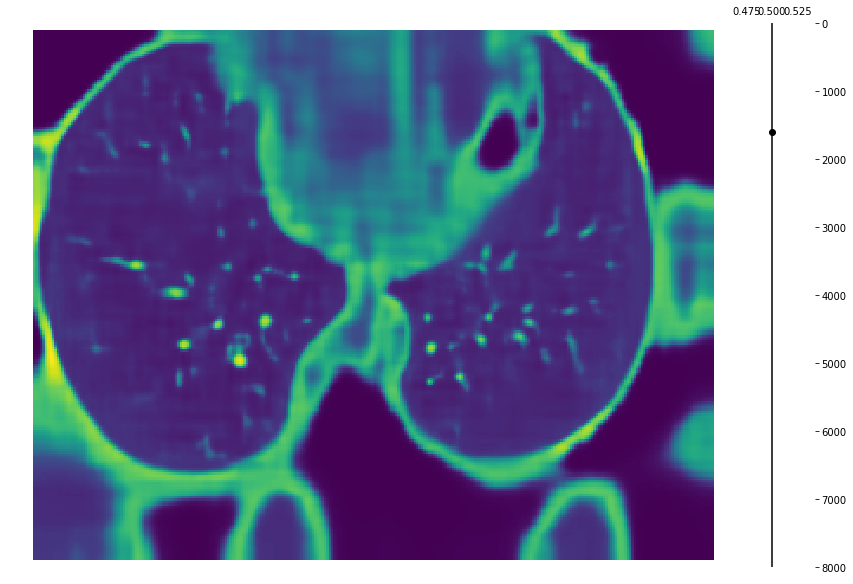

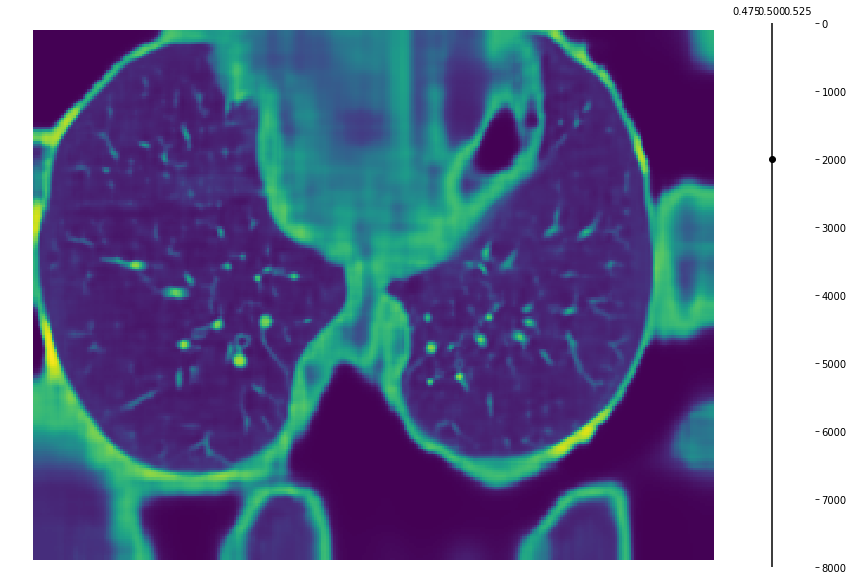

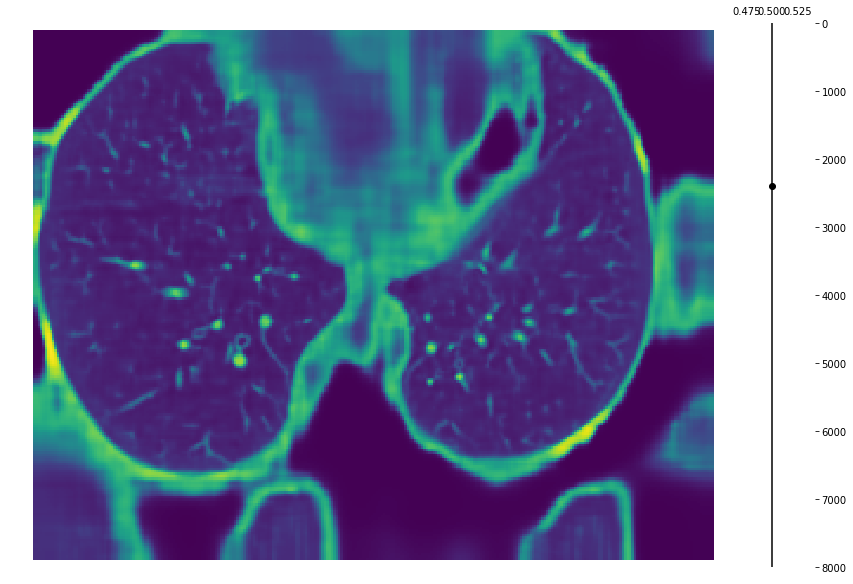

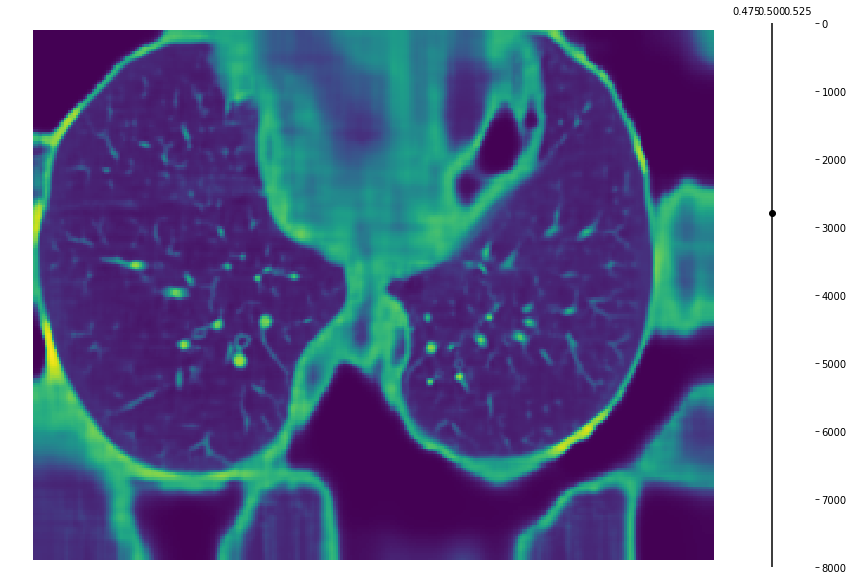

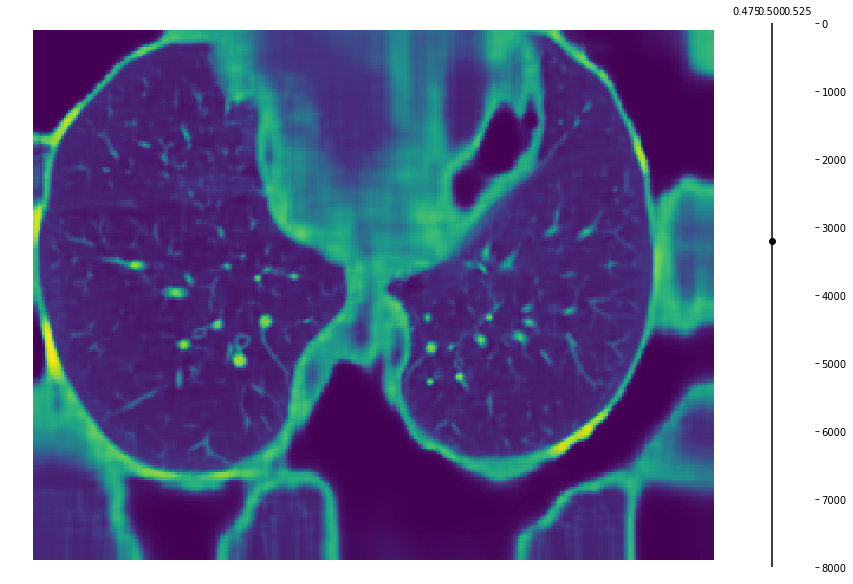

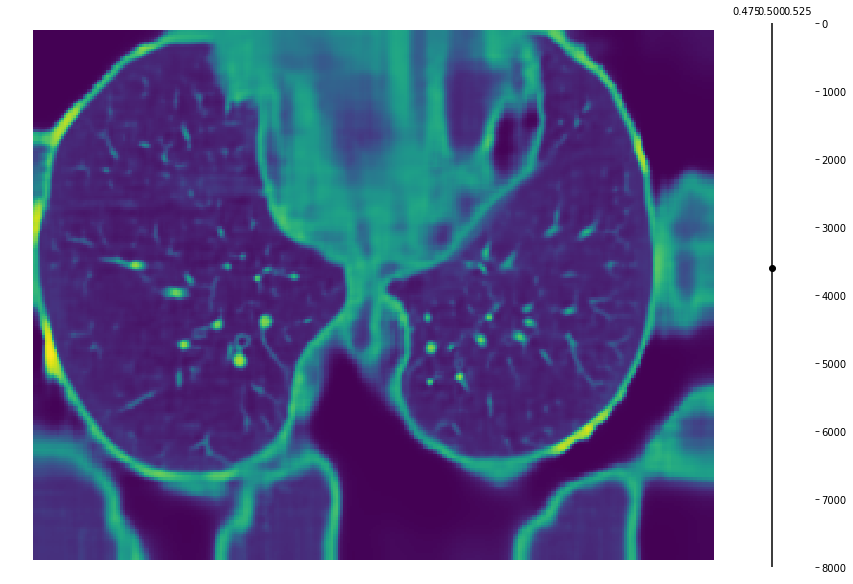

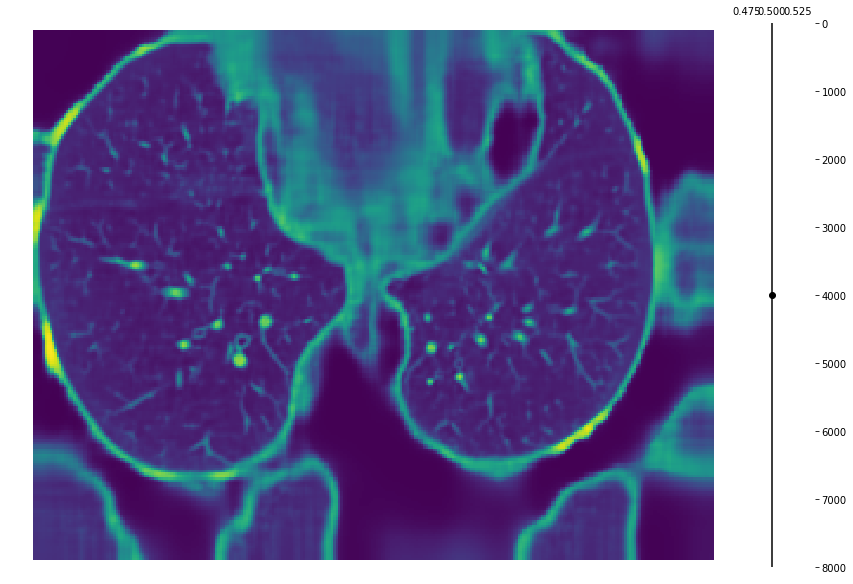

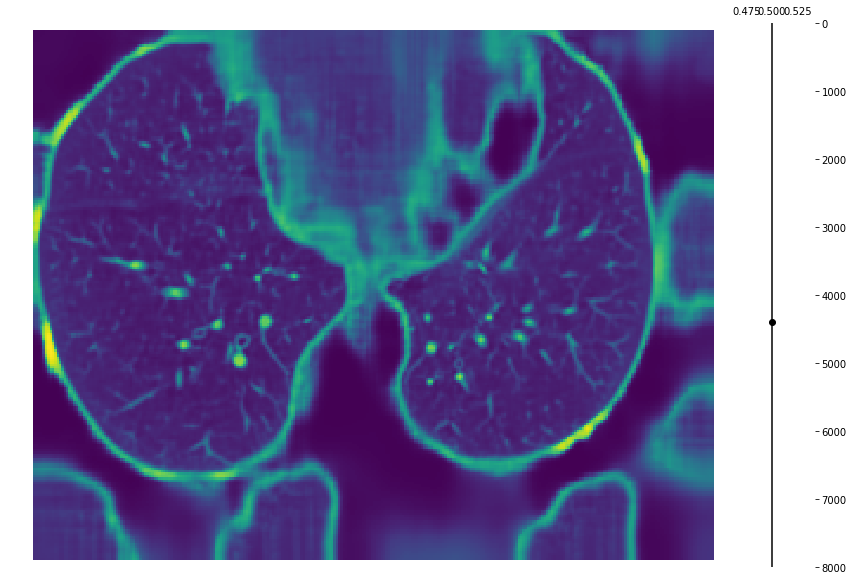

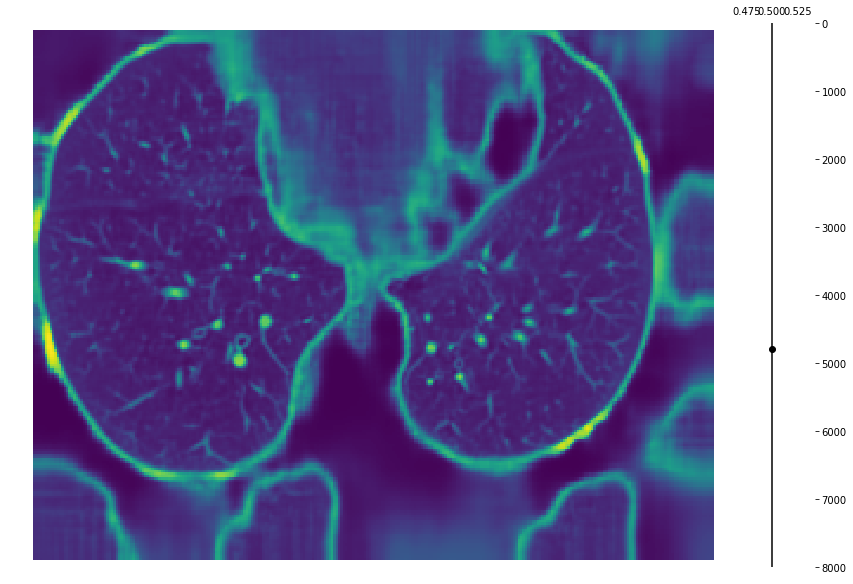

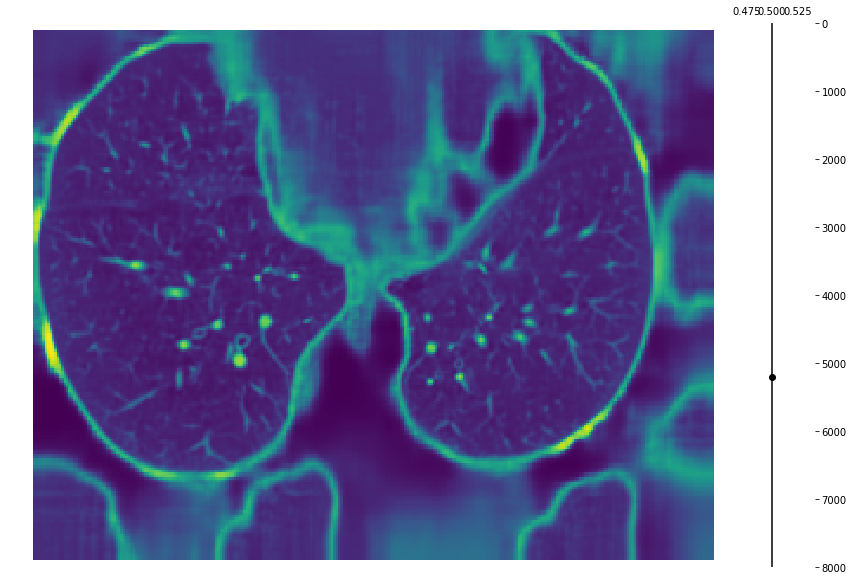

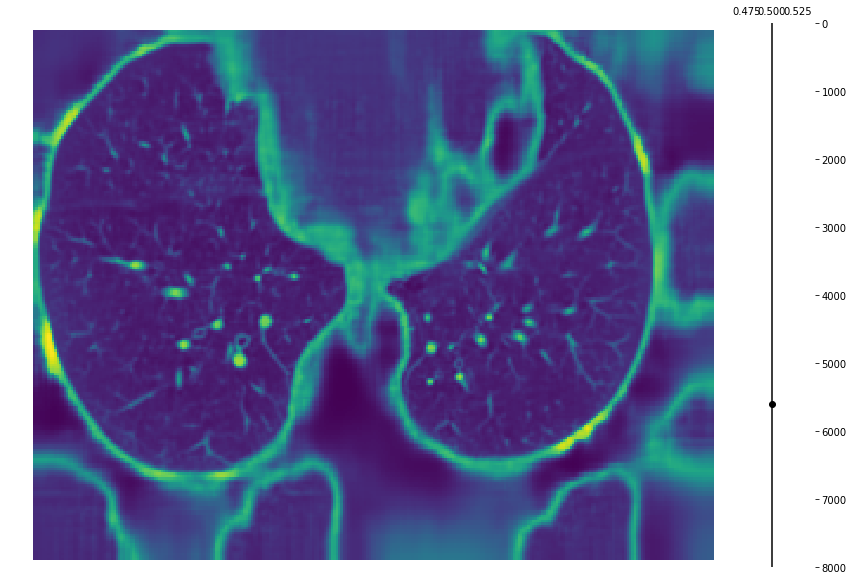

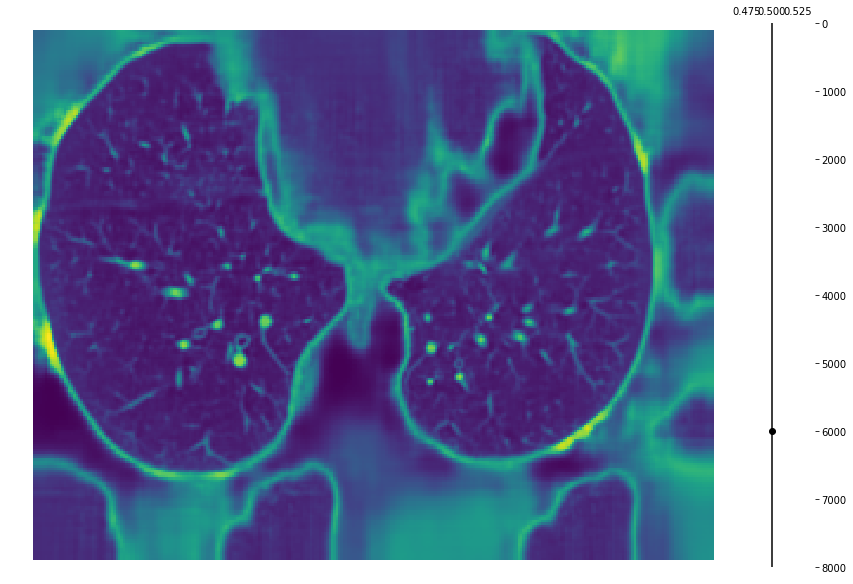

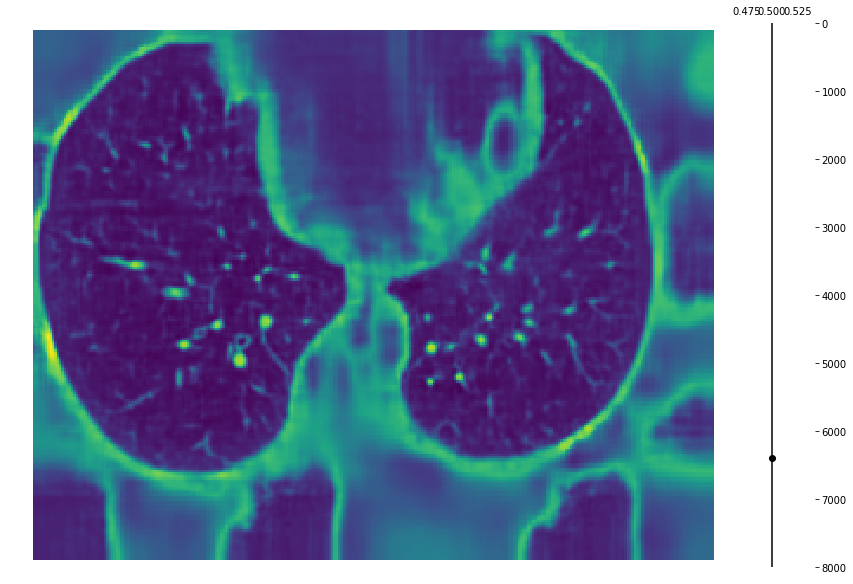

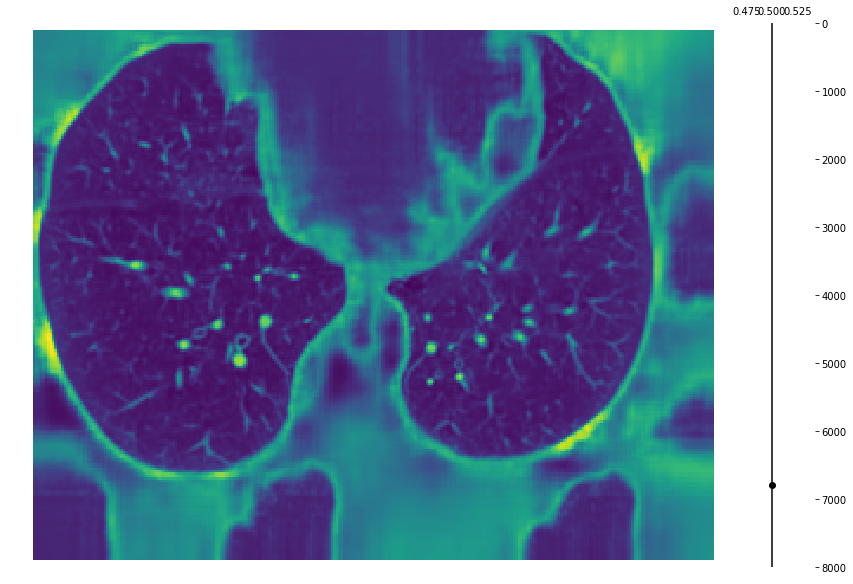

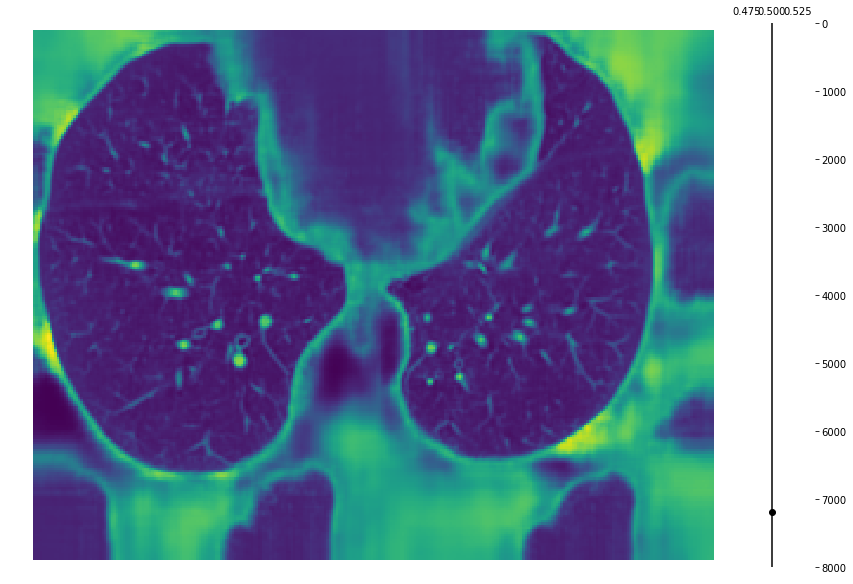

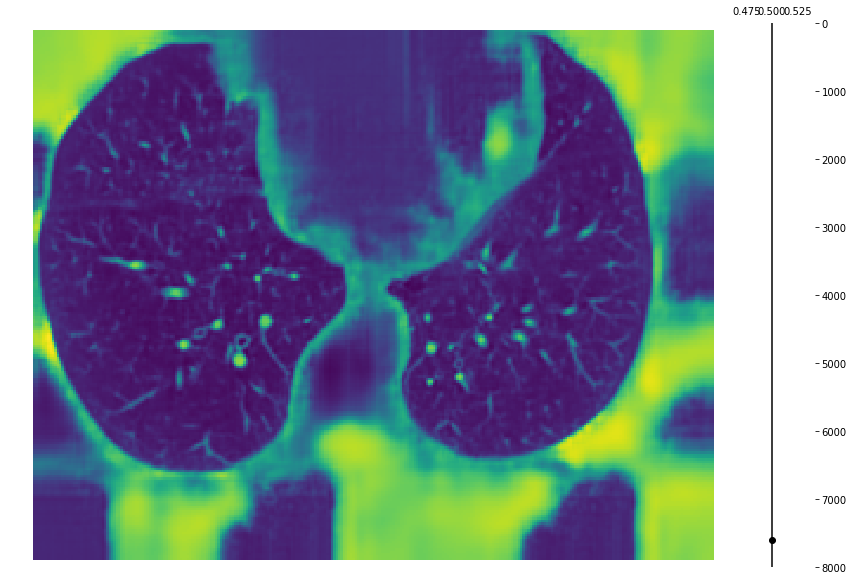

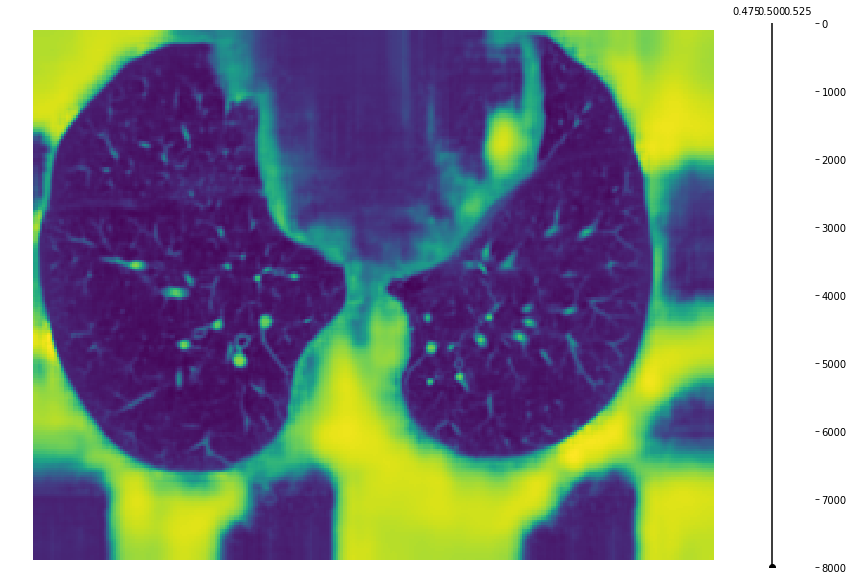

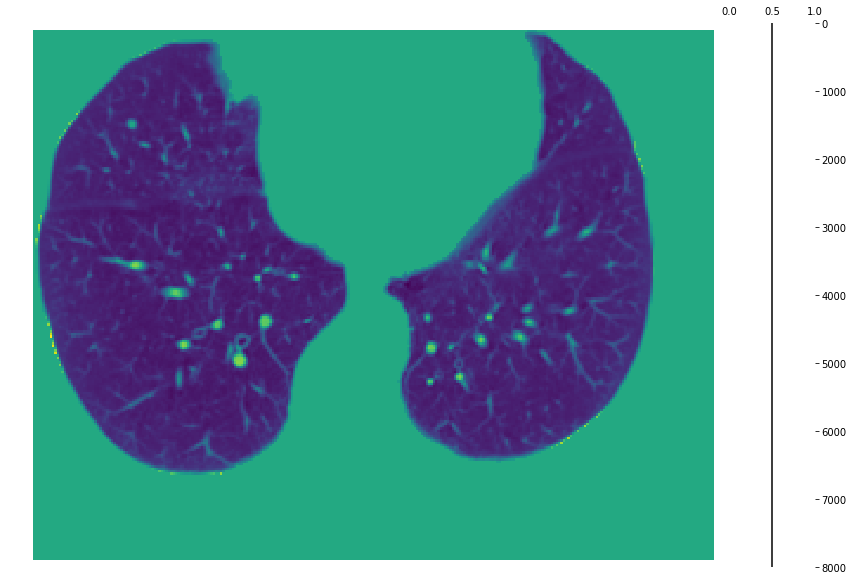

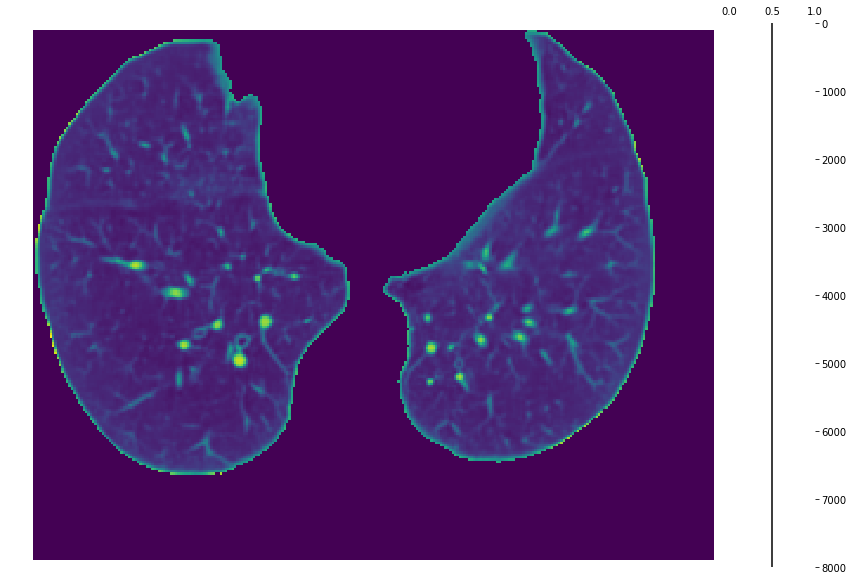

In [47]:
mse_error = []
i = 0
def closure():
    
    global i
    
    images_all = []
#     image_to_save= [] 
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
#     print(np.shape(out))
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        if np.shape(out_np)[0] == 1:
            image_to_save = out_np[0]
#         plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        plot_for_gif(image_to_save, num_iter, i)
        images_all.append(image_to_save)
        
    i += 1
    
#     if  PLOT and i % show_every == 0: image_generated = image_to_save
#     else: image_generated = []
    
    return total_loss, images_all

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)

mse_error, images_generated_all = optimize(OPTIMIZER, p, closure, LR, num_iter, show_every)

# Create gif and keep the last image created and the original image
images_to_gif = os.listdir(f'{path_img_dest}images before gifs/')
images_to_gif = np.sort(images_to_gif)
images_together=[imageio.imread(f'{path_img_dest}images before gifs/{i}') for i in images_to_gif]
#imageio.imsave(f'{path_img_dest}gifs/dip {idname} last.jpeg',images_together[-1])
save_original(img_np[0],idname, 'orig')
imageio.mimsave(f'{path_img_dest}gifs/dip {idname}.gif', images_together, duration = 0.2)
image_last = images_generated_all[-1][0] * (1-outside_lungs[0])
#imageio.imsave(f'{path_img_dest}gifs/dip {idname} last.jpeg',image_last)
save_original(image_last,idname, num_iter)

# Remove all images
images_all = os.listdir(f'{path_img_dest}images before gifs/')
images_all = np.sort(images_all)
_ =[os.remove(f'{path_img_dest}images before gifs/{i}') for i in images_all]

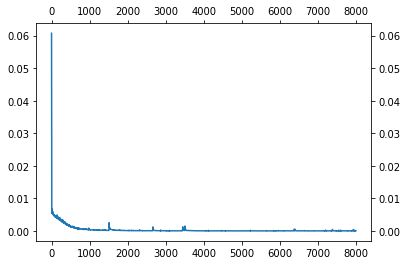

In [56]:
plt.plot(mse_error)

/home/om18/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


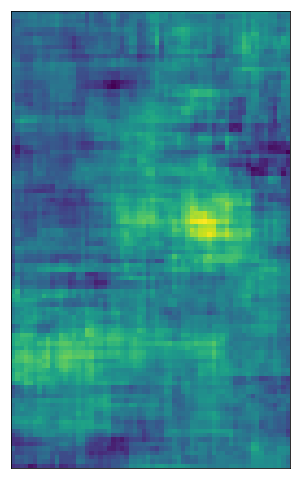

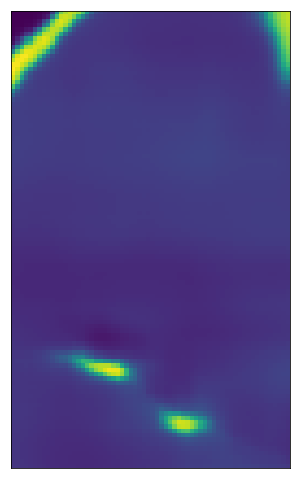

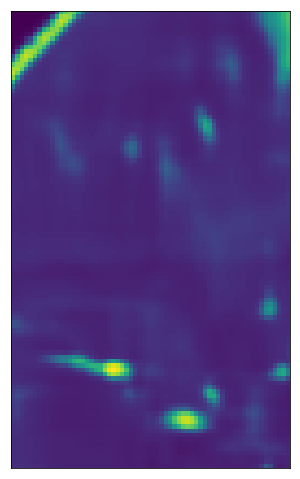

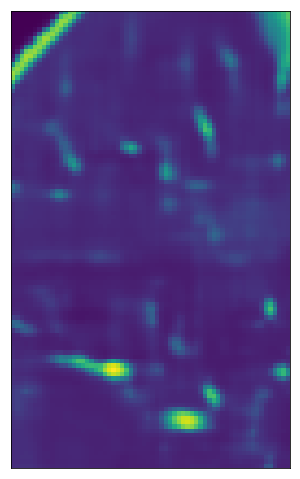

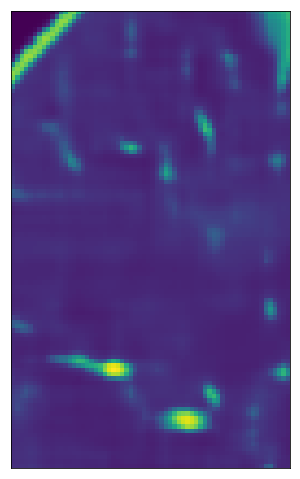

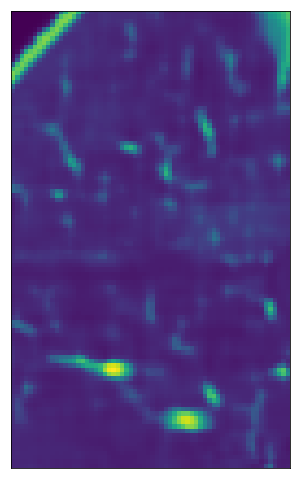

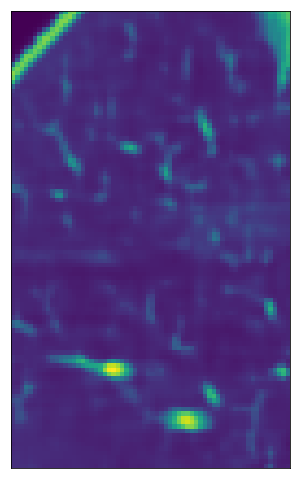

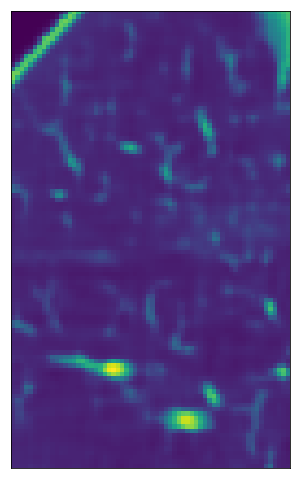

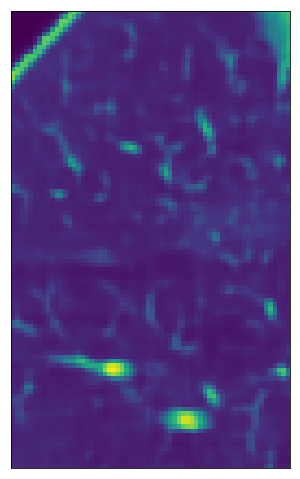

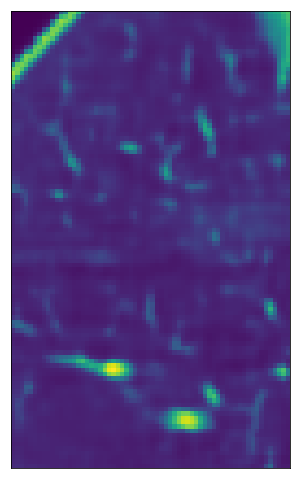

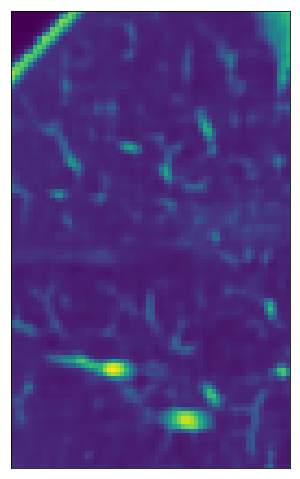

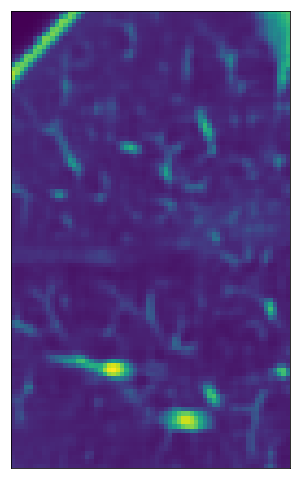

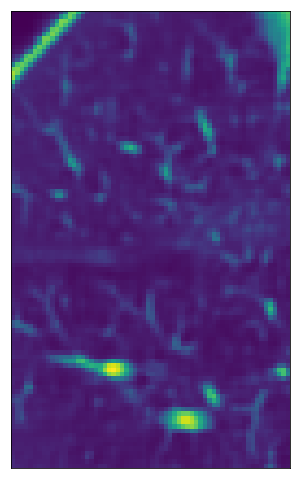

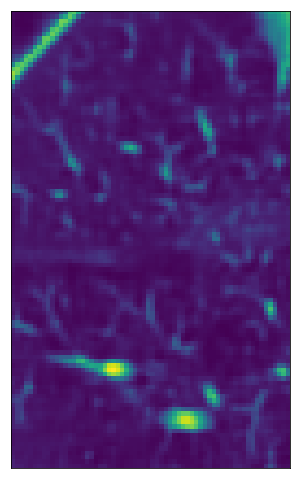

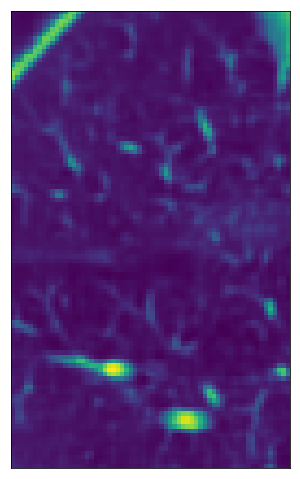

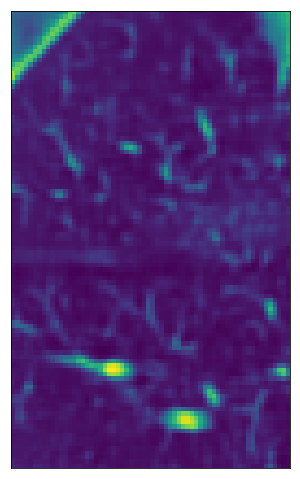

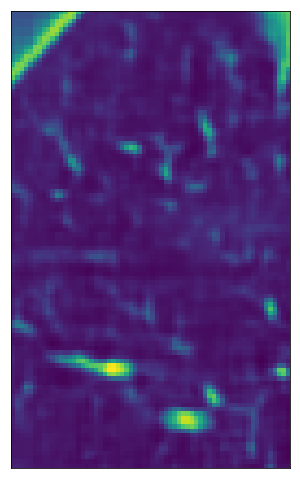

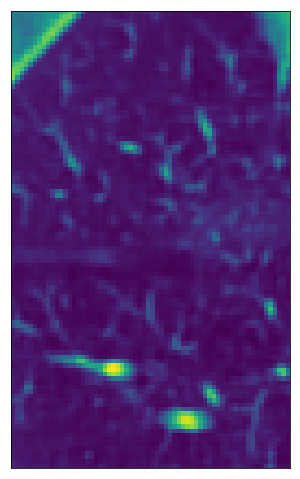

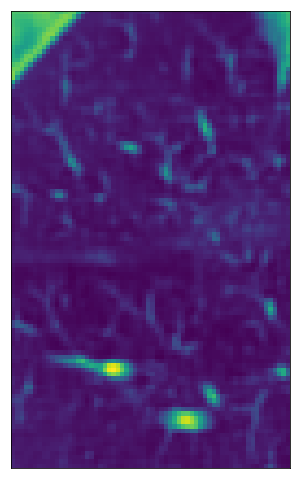

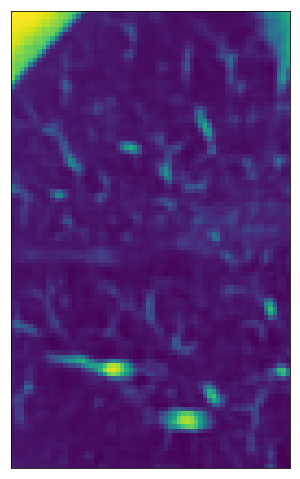

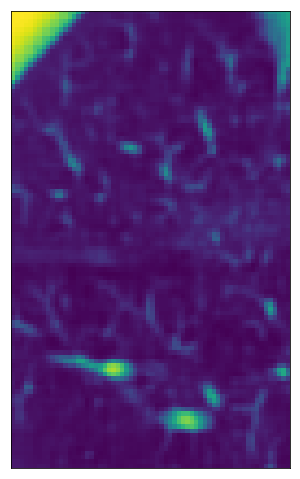

In [85]:
extra = 20
one_generated = np.asarray(images_generated_all[-1])
for idx, i in enumerate(np.asarray(images_generated_all)):
    fig, ax = plt.subplots(1,1, figsize=(5,10))
    ax.imshow(i[0,np.min(y)-extra:np.max(y)+extra*4, np.min(x)-extra:np.max(x)+extra*2])
    fig.savefig(f'{path_img_dest}gifs/dip LIDC-IDRI-0012 zoom {idx*400}.jpeg',
                bbox_inches = 'tight',pad_inches = 0)

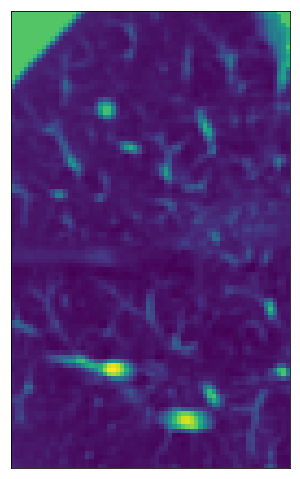

In [89]:
extra=20
mask_slice_zoom = 1-mask_slice
fig, ax = plt.subplots(1,1, figsize=(5,10))
ax.imshow(lungs_slice[0,np.min(y)-extra:np.max(y)+extra*4, np.min(x)-extra:np.max(x)+extra*2])
#ax.imshow(mask_slice_zoom[0,np.min(y)-extra:np.max(y)+extra*4, np.min(x)-extra:np.max(x)+extra*2], alpha=.4)
fig.savefig(f'{path_img_dest}gifs/dip LIDC-IDRI-0012 zoom orig.jpeg',
            bbox_inches = 'tight',pad_inches = 0)

In [77]:
type(lungs_slice)

numpy.ndarray

In [ ]:
image_last = images_generated_all[-1][0] * (1-outside_lungs[0])

In [79]:
np.shape(one_generated)

NameError: name 'one_generated' is not defined

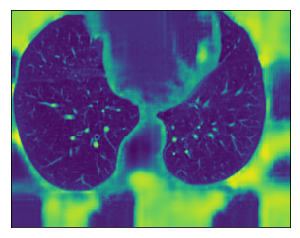

In [62]:
set_all_rcParams(False)
plt.imshow(images_generated_all[-2][0])

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(img_np[0], interpolation=None)


In [ ]:
plt.plot(mse_error)
plt.xlim([0,200])

In [ ]:
# if 'vase.png' in img_path:
#     INPUT = 'meshgrid'
#     input_depth = 2
#     LR = 0.01 
#     num_iter = 5001
#     param_noise = False
#     show_every = 50
#     figsize = 5
#     reg_noise_std = 0.03
    
#     net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [128] * 5,
#                num_channels_up   = [128] * 5,
#                num_channels_skip = [0] * 5,  
#                upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
# elif ('kate.png' in img_path) or ('peppers.png' in img_path):
#     # Same params and net as in super-resolution and denoising
#     INPUT = 'noise'
#     input_depth = 32
#     LR = 0.01 
#     num_iter = 6001
#     param_noise = False
#     show_every = 50
#     figsize = 5
#     reg_noise_std = 0.03
    
#     net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [128] * 5,
#                num_channels_up =   [128] * 5,
#                num_channels_skip =    [128] * 5,  
#                filter_size_up = 3, filter_size_down = 3, 
#                upsample_mode='nearest', filter_skip_size=1,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
# elif 'library.png' in img_path:
    
#     INPUT = 'noise'
#     input_depth = 1
    
#     num_iter = 3001
#     show_every = 50
#     figsize = 8
#     reg_noise_std = 0.00
#     param_noise = True
    
#     if 'skip' in NET_TYPE:
        
#         depth = int(NET_TYPE[-1])
#         net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
#                num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
#                num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
#                filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
#                upsample_mode='nearest', # downsample_mode='avg',
#                need1x1_up=False,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
#         LR = 0.01 
        
#     elif NET_TYPE == 'UNET':
        
#         net = UNet(num_input_channels=input_depth, num_output_channels=3, 
#                    feature_scale=8, more_layers=1, 
#                    concat_x=False, upsample_mode='deconv', 
#                    pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
#         LR = 0.001
#         param_noise = False
        
#     elif NET_TYPE == 'ResNet':
        
#         net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
#         LR = 0.001
#         param_noise = False
        
#     else:
#         assert False
# else:
#     assert False

# net = net.type(dtype)
# net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

# Choose figure

In [ ]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
# img_path  = 'data/inpainting/kate.png'
# mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

# img_pil, img_np = get_image(img_path, imsize)
# img_mask_pil, img_mask_np = get_image(mask_path, imsize)

# img_mask_pil = crop_image(img_mask_pil, dim_div_by)
# img_pil      = crop_image(img_pil,      dim_div_by)

# img_np      = pil_to_np(img_pil)
# img_mask_np = pil_to_np(img_mask_pil)

# np.shape(img_np), np.shape(img_mask_np)

# img_mask_var = np_to_torch(img_mask_np).type(dtype)

# plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);